# 2x Single-Image Super-Resolution on Grayscale Images

**Assignment:** Individual Class Project<br>
**Author:** Richard Hemphill<br>
**ID:** 903877709<br>
**Class:** ECE5268 Theory of Neural Networks<br>
**Instructor:** Dr. Georgios C. Anagnostopoulos<br>
**Description:** Using small-sized grayscale images, construct a CNN-based architecture that will downscale (magnify) the images by a factor of 2.<br>
**Emphasis:** Describe the concept of single-image super-resolution, describe the architecture in sufficient detail and show indicative training and post-training results.<br>


**References:**
* https://www.kaggle.com/spaceengineer1/alexonly-greyscale
* https://www.kaggle.com/c/two-sigma-financial-news/discussion/83593
* https://scikit-image.org/docs/dev/auto_examples/transform/plot_rescale.html

In [837]:
# Imports
import os.path
import numpy as np
import random
import shutil
import glob
import PIL
from IPython.display import display
from pathlib import Path
from zipfile import ZipFile
from kaggle.api.kaggle_api_extended import KaggleApi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [838]:
# Constants
CURRENT_DIRECTORY = '.'
RANDRANGE_STOP = 10000
EPOCHS = 2
BATCH_SIZE = 10
IMAGE_SET_OWNER = 'spaceengineer1'
IMAGE_SET_FILE = 'alexonly-greyscale'
ZIP_EXTENSION = 'zip'
IMAGE_EXTENSION = 'jpg'
PROCESSED_IMAGE_FOLDER ='dataSet'
TRAIN_FOLDER = 'train'
TEST_FOLDER = 'test'
RESCALE_FACTOR = 255.0
VALIDATION_SPLIT = 0.2
CHANNELS = 1
ORIG_IMG_SIZE = 64
UPSCALE_FACTOR = 2
LOW_RES_IMG_SIZE = int(ORIG_IMG_SIZE/UPSCALE_FACTOR)

## Prepocessing

In [839]:
# Extract raw image set
def DownloadImageSet(imageSetOwner = IMAGE_SET_OWNER, imageSetFile = IMAGE_SET_FILE):
    zipFile = '{}.{}'.format(imageSetFile, ZIP_EXTENSION)
    if not os.path.isfile(zipFile):
        # connect to the Kaggle Database and download dataset
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files('{}/{}'.format(imageSetOwner, imageSetFile))
    # extract the dataset
    zf = ZipFile(zipFile)
    topDir = ''.join({item.split('/')[0] for item in zf.namelist()})
    if not os.path.isdir(topDir):
        zf.extractall() 
        zf.close()

    trainDirPre = os.path.join(topDir,TEST_FOLDER)
    if os.path.isdir(trainDirPre):
        shutil.move(trainDirPre, CURRENT_DIRECTORY)
        
    return topDir

In [840]:
# Pre Process Images
imgFolder = DownloadImageSet()

In [841]:
def ImageNorm(image):
    image = image/RESCALE_FACTOR
    return image

In [842]:
def Shrink(input):
    return tf.image.resize(input,[LOW_RES_IMG_SIZE,LOW_RES_IMG_SIZE],method='area')

In [843]:
trainSet = image_dataset_from_directory(
    directory=imgFolder,
    batch_size=BATCH_SIZE,
    image_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE),
    validation_split=VALIDATION_SPLIT,
    subset='training',
    color_mode='grayscale',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 804 files belonging to 1 classes.
Using 644 files for training.


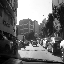

In [844]:
for batch in trainSet.take(1):
    display(array_to_img(batch[0]))

In [845]:
trainSet = trainSet.map(ImageNorm)
trainSet = trainSet.map(lambda x: (Shrink(x),x))

In [846]:
valSet = image_dataset_from_directory(
    directory=imgFolder,
    batch_size=BATCH_SIZE,
    image_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE),
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    color_mode='grayscale',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 804 files belonging to 1 classes.
Using 160 files for validation.


In [847]:
valSet = valSet.map(ImageNorm)
valSet = valSet.map(lambda x: (Shrink(x),x))

## Create Model

In [848]:
def SuperResolution(upscaleFactor=UPSCALE_FACTOR, channels=CHANNELS):

    inputs = keras.Input(shape=(None, None, channels))
    x = keras.layers.Conv2D(filters=64, kernel_size=9, activation='relu', padding='same')(inputs)
    x = keras.layers.Conv2D(filters=32, kernel_size=1, activation='relu', padding='same')(x)
    x = keras.layers.Conv2D(filters=(channels * (upscaleFactor ** 2)), kernel_size=5, activation='relu', padding='same')(x)
    outputs = tf.nn.depth_to_space(x, upscaleFactor)

    return keras.Model(inputs, outputs)

In [849]:
sr = SuperResolution()
sr.summary()

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_155 (Conv2D)          (None, None, None, 64)    5248      
_________________________________________________________________
conv2d_156 (Conv2D)          (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_157 (Conv2D)          (None, None, None, 4)     3204      
_________________________________________________________________
tf.nn.depth_to_space_35 (TFO (None, None, None, 1)     0         
Total params: 10,532
Trainable params: 10,532
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In [850]:
srOpt = keras.optimizers.SGD(learning_rate=0.001)
srLossFn = keras.losses.MeanSquaredError()
sr.compile(optimizer=srOpt, loss=srLossFn)

In [851]:
sr.fit(trainSet, epochs=EPOCHS, validation_data=valSet, verbose=0)

## Test the Model

In [852]:
def MagnifyImage(model, lowResImg):
    lowResArr = img_to_array(lowResImg)
    lowResArr = lowResArr.astype('float32')/RESCALE_FACTOR
    input = np.expand_dims(lowResArr, axis=0)
    out = model.predict(input)
    out *= RESCALE_FACTOR
    out = out.reshape((ORIG_IMG_SIZE,ORIG_IMG_SIZE))
    return out

In [853]:
for idx, testImgPath in enumerate(testImgPaths):
    img = load_img(testImgPath)
    lowResImg = img.resize((LOW_RES_IMG_SIZE,LOW_RES_IMG_SIZE), resample=PIL.Image.BICUBIC)
    #superResImg = MagnifyImage(sr,lowResImg)

ValueError: in user code:

    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\functional.py:425 call
        inputs, training=training, mask=mask)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\richa\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer conv2d_155 is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape (None, 32, 32, 3)
